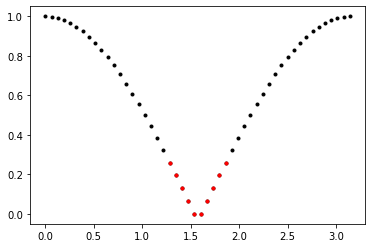

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import norm
t = np.linspace(0, np.pi/2, 25)
v = np.linspace(0, np.pi, 50).reshape(-1,1)
pts_A = np.cos(t)
pts_B = np.sin(t)

pts_AB = np.concatenate([pts_A, pts_B], axis=0).reshape(-1,1)
pts = np.concatenate([v, pts_AB], axis=1)
neighbors = np.arange(20,30)

fig, ax = plt.subplots()
x,y = pts.T
ax.plot(x,y, '.k')
x,y = pts[neighbors].T
ax.plot(x,y, '.r')
plt.show()

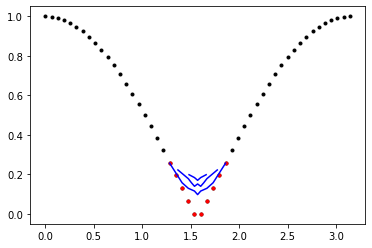

In [2]:
# Mean filtering
# def filter_mean(all_pts, neighbor_pts):
def filter_mean(all_pts, neighbors):
    neighbor_pts = all_pts[neighbors]
    distances = cdist(neighbor_pts, all_pts)
    DISTANCE = 0.35
    mask = distances < DISTANCE
    mask_3D = np.expand_dims(mask, axis=2)

    summed = (all_pts * mask_3D).sum(axis=1)
    counts = np.count_nonzero(mask, axis=1, keepdims=True)
    new_pts = summed / counts

    updated_pts = all_pts.copy()
    updated_pts[neighbors] = new_pts

    return updated_pts, new_pts

all_pts = pts
fig, ax = plt.subplots()
x,y = pts.T
ax.plot(x,y, '.k')
x,y = pts[neighbors].T
ax.plot(x,y, '.r')

for i in range(3):
    all_pts, new_pts = filter_mean(all_pts, neighbors)
    x,y = new_pts.T
    ax.plot(x,y, '-b')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


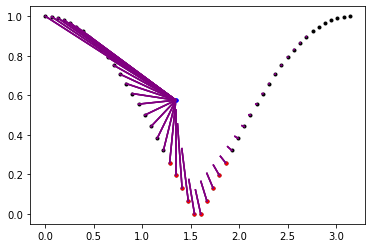

In [3]:
# Mean again
# def filter_mean(all_pts, neighbor_pts):
# 

def filter_sigmoid(all_pts, point_idx, distance):

    def sigmoid(x, k=1):
        # sigmoid function
        # use k to adjust the slope
        assert x.min() >= 0
        assert x.max() <= 1
        #!!! Altered to work for x in range [0, 1]
        s = 1 / (1 + np.exp(-((2*x-1) / k))) 
        return s

    point = all_pts[point_idx].mean(axis=0, keepdims=True)

    # Find neighbors within specified distance of point
    distances = cdist(all_pts, point)
    neighbors = np.argwhere(distances < DISTANCE).T[0]
    print(neighbors)

    # Find average position of these neighbors
    average_of_neighbors = all_pts[neighbors].mean(axis=0)

    # Shift vertices based on proximity to point
    all_pts_vec = average_of_neighbors - all_pts
    weights = (DISTANCE - distances) / DISTANCE
    weights[weights<0] = 0
    weights = weights ** 1 #  Scale each one down
    weights = sigmoid(weights, k=0.1)
    new_pts = all_pts + weights * all_pts_vec

    return new_pts, average_of_neighbors, neighbors

all_pts = pts
DISTANCE = 2
point_idx = [11,12]
fig, ax = plt.subplots()
x,y = all_pts.T
ax.plot(x,y, '.k')
x,y = all_pts[neighbors].T
ax.plot(x,y, '.r')
for i in range(3):
    new_pts, average_of_neighbors, neighbors = filter_sigmoid(all_pts, point_idx, distance=DISTANCE)
    x,y = average_of_neighbors
    ax.plot(x,y, '.b')

    for i, n in enumerate(neighbors):
        
        p1 = all_pts[n]
        p2 = new_pts[n]
        x,y = zip(p1, p2)
        ax.plot(x,y, "-", color="purple")
    # x,y = all_pts[neighbors].T
    # ax.plot(x,y, '-', color='purple')
plt.show()

In [4]:
neighbors

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

In [5]:
# Gaussian filter
# def filter_mean(all_pts, neighbor_pts):
# def filter_gaussian(all_pts, point, sigma):
all_pts = pts
sigma = 0.25

# Find z_scores of all points
distances = cdist(all_pts, point)
z_scores = distances/sigma

# Find average position of these neighbors
average_of_neighbors = all_pts[neighbors].mean(axis=0)

# Shift vertices based on proximity to point
all_pts_vec = average_of_neighbors - all_pts
weights = (DISTANCE - distances) / DISTANCE
weights[weights<0] = 0
new_pts = all_pts + weights * all_pts_vec

fig, ax = plt.subplots()
x,y = all_pts.T
ax.plot(x,y, '.k')
x,y = all_pts[neighbors].T
ax.plot(x,y, '.r')
x,y = average_of_neighbors
ax.plot(x,y, '.b')
x,y = new_pts[neighbors].T
ax.plot(x,y, '-', color='purple')
plt.show()

NameError: name 'point' is not defined

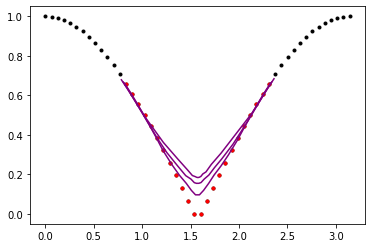

In [ ]:
# Gaussian filter #2
# def filter_mean(all_pts, neighbor_pts):
# def filter_gaussian(all_pts, point, sigma):

def filter_gaussian(all_pts, neighbors, distance):
    new_pts = all_pts.copy()
    for n in neighbors:
        
        # Indices of adjacent
        n_pt = all_pts[n].reshape(1,-1)
        distances = cdist(n_pt, new_pts)[0]
        adjacent = np.argwhere(distances<distance).ravel()
        
        # Lengths to adjacent
        adjacent_pts = all_pts[adjacent]
        lengths = cdist(adjacent_pts, n_pt)
        average_length = lengths.mean()

        # Weight each neighboring vertex by gaussian function
        sigma = average_length
        weights = np.exp(-(lengths**2) / (2*sigma**2))
        weights = weights / weights.sum()  # Normalize weights to sum to 1

        # Use weights of adjacent to find new position
        new_pt = (adjacent_pts * weights).sum(axis=0)
        new_pts[n] = new_pt
    return new_pts
all_pts = pts
fig, ax = plt.subplots()
x,y = all_pts.T
ax.plot(x,y, '.k')
x,y = all_pts[neighbors].T
ax.plot(x,y, '.r')

for i in range(3):
    new_pts = filter_gaussian(all_pts, neighbors,0.5)
    all_pts = new_pts
    x,y = new_pts[neighbors].T
    ax.plot(x,y, '-', color='purple')
plt.show()

In [1]:
import igl
import scipy as sp
import numpy as np
from meshplot import plot, subplot, interact
import meshplot
import matplotlib.pyplot as plt
import os
from objects import *

root_folder = os.getcwd()

v, f = igl.read_triangle_mesh(os.path.join(root_folder, "bump_domain.obj"))
u = v.copy()

# Find boundary vertices outside annulus
vrn = np.linalg.norm(v, axis=1)
is_outer = [vrn[i] - 1.00 > -1e-15 for i in range(v.shape[0])]
is_inner = [vrn[i] - 0.15 < 1e-15 for i in range(v.shape[0])]
in_b = [is_outer[i] or is_inner[i] for i in range(len(is_outer))]

b = np.array([i for i in range(v.shape[0]) if (in_b[i])]).T
bc = np.zeros(b.size)

for bi in range(b.size):
    bc[bi] = 0.0 if is_outer[b[bi]] else 1.0

c = np.array(is_outer)

# fig = plt.figure()
# ax = plt.axes(projection="3d")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# ax.view_init(elev=-90, azim=90)

# # Entire mesh
# x, y, z = v.T
# ax.plot(x, y, z, ".", color="black")

# x, y, z = v[is_outer].T
# ax.plot(x, y, z, ".", color="green")

# x, y, z = v[is_inner].T
# ax.plot(x, y, z, ".", color="red")

# x, y, z = v[b[bc.astype("bool")]].T
# ax.plot(x, y, z, ".", color="purple")
# plt.show()

for i in range(1,5):
    z = igl.harmonic_weights(v, f, b, bc, int(i))
    u[:, 2] = z
    if i == 1:
        p = subplot(u, f, c, shading={"wire_width": 0.01, "colormap": "tab10"}, s=[1, 4, i-1])
    else:
        subplot(u, f, c, shading={"wire_width": 0.01, "colormap": "tab10"}, s=[1, 4, i-1], data=p)
p

ValueError: Out of range float values are not JSON compliant

In [9]:
v=None

array([[ 508,  595,  509],
       [ 234,  230,  513],
       [ 240,  589,  241],
       ...,
       [3971, 4170, 3961],
       [2113, 4171, 1348],
       [ 812, 4171, 1666]], dtype=int64)